# End-to-End Demonstration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reddragon/efficient-dl-survey-paper/blob/main/demo.ipynb)

This colab demonstrates various efficiency techniques as described in the [Efficient Deep Learning paper](https://arxiv.org/abs/2106.08962) on the CIFAR-10 dataset and a CNN-based model family.

## Creating the Dataset

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
from keras.utils import np_utils

import tensorflow_datasets as tfds
def load_data():
  """Loads CIFAR10 dataset."""
  cifar10_data = tfds.load("cifar10")
  x_train = np.zeros([50000, 32, 32, 3], dtype=np.uint8)
  y_train = np.zeros([50000, 1], dtype=np.uint8)
  i = 0
  for example in tfds.as_numpy(cifar10_data['train']):
    x_train[i] = example['image']
    y_train[i] = example['label']
    i = i + 1

  x_test = np.zeros([10000, 32, 32, 3])
  y_test = np.zeros([10000, 1])
  i = 0
  for example in tfds.as_numpy(cifar10_data['test']):
    x_test[i] = example['image']
    y_test[i] = example['label']
    i = i + 1

  return (x_train, y_train), (x_test, y_test)

def normalize_x(x):
  x = x.astype('float32')
  x /= 127.5
  x -= 1.0
  # TODO: Remove
  # mean = np.mean(x,axis=(0,1,2,3))
  # std = np.std(x,axis=(0,1,2,3))
  # x = (x-mean)/(std+1e-7)
  # x = np.reshape(x, [-1, 32*32*3])
  return x

def normalize_y(y, num_classes):
  if y.shape[1] == 1:
    y = np_utils.to_categorical(y, num_classes)
  return y

def get_data(dataset, num_classes=10):
  (train_x, train_y), (test_x, test_y) = load_data()
  return normalize_x(train_x), normalize_y(train_y, num_classes), normalize_x(test_x), normalize_y(test_y, num_classes)

cifar10_train_x, cifar10_train_y, cifar10_test_x, cifar10_test_y = get_data(10)

## Defining the Model

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers


def base_model(
    num_classes=10,        # Number of classes in the model. 
    width_multiplier=1.0,  # Factor for scaling the network size.
    params={},             # Additional hyper-params.
):
  # Use the width_multiplier for scaling the network, the larger the value,
  # the larger the network. Keep a bound on the width though.
  w = min(max(width_multiplier, 0.05), 3.0)

  inputs = keras.Input(shape=(32, 32, 3))
  x = inputs

  # Add a data augmentation module, that can be turned on/off with
  # hyper-params.
  if params.get('data_augmentation', True):
    if params.get('easier_data_augmentation', False):
      data_augmentation_module = keras.Sequential([
          layers.experimental.preprocessing.RandomFlip('horizontal'),
          # layers.experimental.preprocessing.RandomTranslation(3. / 32, 3. / 32),
          # TODO: Remove this, only valid for wm=1.4
          # layers.experimental.preprocessing.RandomTranslation(3. / 32, 3. / 32),
          # layers.experimental.preprocessing.RandomContrast(0.2),
          # layers.experimental.preprocessing.RandomFlip('vertical'),
      ])
    else:
      data_augmentation_module = keras.Sequential([
          layers.experimental.preprocessing.RandomFlip('horizontal'),
          # layers.experimental.preprocessing.RandomTranslation(3. / 32, 3. / 32),
          # TODO: Remove this, only valid for wm=1.4
          layers.experimental.preprocessing.RandomTranslation(3. / 32, 3. / 32),
          # layers.experimental.preprocessing.RandomContrast(0.2),
          # layers.experimental.preprocessing.RandomFlip('vertical'),
      ])

    x = data_augmentation_module(inputs)

  # Create a regularizer to be used.
  reg = keras.regularizers.l2(params.get('l2_reg_weight', 2e-4))

  # Find the dropout rate for helping with further regularization.
  dropout_rate = params.get('dropout_rate', 1.0)

  # We will keep the first 'block' of layers scale invariant.

  x = layers.Conv2D(
      32, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(
          x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(
      32, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(
          x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  # x = layers.Dropout(dropout_rate)(x)

  # A short hand for the round method.
  r = lambda v: round(v)

  # We will start to scale layers from here on.
  x = layers.Conv2D(
      # Note that the number of filters grows / shrinks with `w`.
      r(64 * w), 
      (3, 3), 
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(
      r(64 * w), 
      (3, 3),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  # x = layers.Dropout(dropout_rate)(x)

  x = layers.Conv2D(
      r(128 * w), 
      (3, 3),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(
      r(128 * w), 
      (3, 3),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  # x = layers.Dropout(dropout_rate)(x)

  x = layers.Flatten()(x)
  # TODO: Check if we need extra Dense layers in between.
  # x = Dense(512, activation='relu', kernel_regularizer=reg)(x)
  # x = Dropout(0.5)(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(r(512 * w), activation='relu', kernel_regularizer=reg)(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(num_classes, kernel_regularizer=reg)(x)
  logits = x
  probabilities = layers.Activation('softmax')(logits)

  # In case we only want the logits, return just that.
  outputs = logits if params.get('only_logits', False) else probabilities
  return keras.Model(inputs=inputs, outputs=outputs)


base_model()

## Helper Methods for Model Training

In [ ]:
def get_compiled_model(num_classes=10,
                       width_multiplier=1.0,
                       loss_fn='categorical_crossentropy',
                       metric_fn='categorical_accuracy',
                       params={},
                       hp=None):
  if hp:
    learning_rate = hp.Choice('learning_rate', values=[5e-3, 1e-3, 5e-4, 1e-4])
    # decay_rate = hp.Float(
    #     'decay_rate', min_value=0.5, max_value=1.0, sampling='linear')

    params['dropout_rate'] = hp.Choice(
        'dropout_rate', values=[0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15])
    params['l2_reg_weight'] = hp.Choice(
        'l2_reg_weight', values=[1e-3, 2e-4, 1e-5, 1e-6, 0.0])
  else:
    learning_rate = params.get('learning_rate', 1e-3)
    # decay_rate = params.get('decay_rate', 1.0)

  model = base_model(
      num_classes, width_multiplier=width_multiplier, params=params)

  # lr = keras.optimizers.schedules.ExponentialDecay(
  #       initial_learning_rate=initial_lr, decay_steps=10000,
  #       decay_rate=decay_rate)

  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  # opt = keras.optimizers.Adam()
  model.compile(loss=loss_fn, optimizer=opt, metrics=metric_fn)
  return model

In [ ]:
import os

# Create a directory for the checkpoints.
!mkdir -p checkpoints

# Now let us create a callback for saving the best checkpoint so far.
# It tries to find the checkpoint with the maximum categorical accuracy.
# We will provide this to the model.fit function.

CHECKPOINTS_DIR='checkpoints'

def best_checkpoint_callback(model_name):
  checkpoint_dir_path = os.path.join(CHECKPOINTS_DIR, model_name)
  if not os.path.exists(checkpoint_dir_path):
    os.mkdir(checkpoint_dir_path)
  checkpoint_path = os.path.join(checkpoint_dir_path, model_name)
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)


def load_best_checkpoint(model, model_name):
  checkpoint_dir_path = os.path.join(CHECKPOINTS_DIR, model_name)
  checkpoint_path = os.path.join(checkpoint_dir_path, model_name)
  model.load_weights(checkpoint_path)
  return model

In [ ]:
import pickle

!mkdir -p histories

def persist_history(history_obj, model_name):
  history_path = os.path.join('histories', model_name)
  pickle.dump(history_obj, open(history_path, 'wb'))

def load_history(model_name):
  history_path = os.path.join('histories', model_name)
  return pickle.load(open(history_path, 'rb'))

# persist_history(model_wm_20_aug_history.history, 'model_wm_20_aug')
# history = load_history('model_wm_20_aug')

In [ ]:
# TODO: Uncomment later.
# keras.utils.plot_model(model_wm_01)

### TFLite Export and Eval

In [ ]:
def tflite_model_eval(model_content, test_images, test_labels, quantized):
  # Load the TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_content=model_content)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Test the model on random input data.
  input_shape = input_details[0]['shape']

  num_correct = 0
  num_total = 0
  # input_data = np.random.rand(1, 32, 32, 3).astype(np.int8)
  for idx in range(len(test_images)):
    num_total = num_total + 1

    input_data = test_images[idx:idx+1]
    if quantized:
      # Rescale that data to be in [-127, 127] and then convert to int8.
      input_data = (input_data * 127).astype(np.int8)

    # print(test_labels[0])
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # print(output_data)

    # print(test_labels[idx].shape, output_data[0].shape)
    if np.argmax(test_labels[idx]) == np.argmax(output_data[0]):
      num_correct = num_correct + 1
  
  print('Accuracy:', num_correct * 1.0 / num_total)

In [ ]:
# Create the directory for storing TFLite models.
!mkdir -p 'tflite_models'

def convert_and_eval(keras_model, model_name, quantized_export, test_dataset_x, 
                     test_dataset_y):
  converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
  if quantized_export:

    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE, 
                               tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
    def representative_dataset():
      for idx in range(min(len(test_dataset_x), 100)):
        yield [test_dataset_x[idx:idx+1]]

    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8

  converter.use_experimental_new_converter = True
  tflite_model_str = converter.convert()
  model_name = '{}_{}.tflite'.format(
      model_name, ('quantized' if quantized_export else 'float'))
  print('Model Name: {}, Quantized: {}'.format(model_name, quantized_export))
  print('Model Size: {:.2f} KB'.format(len(tflite_model_str) / 1024.))
  with open(os.path.join('tflite_models', model_name), 'wb') as f:
    f.write(tflite_model_str)
  
  tflite_model_eval(tflite_model_str, test_dataset_x, test_dataset_y, 
                    quantized_export)

In [ ]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

### Unified Method for Model Training

In [ ]:
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_model(width_multiplier, params={}, batch_size=128, epochs=100):
  model_name = 'wm_{}_{}'.format(
      str(width_multiplier).replace('.', ''),
      ('aug' if params.get('data_augmentation', False) else 'no_aug')
  )

  model = get_compiled_model(
      width_multiplier=width_multiplier,
      params=params)

  model.summary()

  lr_reducer = ReduceLROnPlateau(
      factor=np.sqrt(0.1),
      cooldown=0,
      patience=5,
      min_lr=0.5e-6)

  data_gen = (width_multiplier > 1.0)
  # Now we can train the model.
  if data_gen:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        # horizontal_flip=True,  # randomly flip images
        # vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(p=0.5, v_l=-1.0, v_h=1.0, s_l = 0.1, pixel_level=False))

    # Fit the model on the batches generated by datagen.flow().
    model_history = model.fit_generator(datagen.flow(cifar10_train_x, cifar10_train_y, batch_size=batch_size),
                        steps_per_epoch=cifar10_train_x.shape[0] // batch_size,
                        validation_data=(cifar10_test_x, cifar10_test_y),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=[best_checkpoint_callback(model_name), lr_reducer],
                        # callbacks=[best_checkpoint_callback(model_name)],
                        )
  else:
    model_history = model.fit(
        cifar10_train_x, 
        cifar10_train_y, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(cifar10_test_x, cifar10_test_y),
        # callbacks=[best_checkpoint_callback(model_name), lr_reducer],
        callbacks=[best_checkpoint_callback(model_name)],
        shuffle=True)

  

  model = load_best_checkpoint(model, model_name)
  model.evaluate(cifar10_test_x, cifar10_test_y)

  convert_and_eval(model, model_name, False, cifar10_test_x, cifar10_test_y)
  convert_and_eval(model, model_name, True, cifar10_test_x, cifar10_test_y)

  persist_history(model_history.history, model_name)
  return model, model_history.history


## Training Models w/ & w/o Augmentation

### Width Multiplier = 0.05

In [ ]:
width_multiplier = 0.05
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'data_augmentation': False,
}
_, wm_005_no_aug_history = train_model(width_multiplier, params)

Model: "model_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_97 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_576 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_576 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_577 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_577 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_288 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_578 (Conv2D)          (None, 16, 16, 3)         867

Accuracy: 0.7017
Model Name: wm_005_no_aug_quantized.tflite, Quantized: True
Model Size: 26.87 KB


Accuracy: 0.699


In [ ]:
width_multiplier = 0.05
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'data_augmentation': True,
    'easier_data_augmentation': True,
}
_, wm_005_aug_history = train_model(width_multiplier, params)

Model: "model_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_76 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_582 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_582 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_583 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_583 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_291 (MaxPoolin (None, 16, 16, 32)        0  

Accuracy: 0.7171
Model Name: wm_005_aug_quantized.tflite, Quantized: True
Model Size: 26.87 KB


Accuracy: 0.7172


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

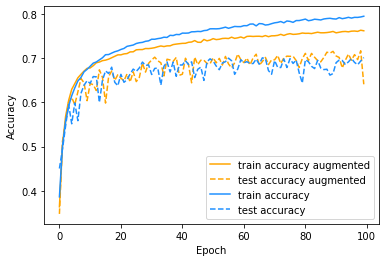

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_005_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_005_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_005_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_005_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.1

In [ ]:
width_multiplier = 0.1
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_01_no_aug_history = train_model(width_multiplier, params)

Model: "model_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_588 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_588 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_589 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_589 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_294 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_590 (Conv2D)          (None, 16, 16, 6)         17

Accuracy: 0.7593
Model Name: wm_01_no_aug_quantized.tflite, Quantized: True
Model Size: 38.55 KB


Accuracy: 0.7598


In [ ]:
width_multiplier = 0.1
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
    'easier_data_augmentation': True,
}
_, wm_01_aug_history = train_model(width_multiplier, params)

Model: "model_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_100 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_77 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_594 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_594 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_595 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_595 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_297 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.7822
Model Name: wm_01_aug_quantized.tflite, Quantized: True
Model Size: 38.55 KB


Accuracy: 0.7819


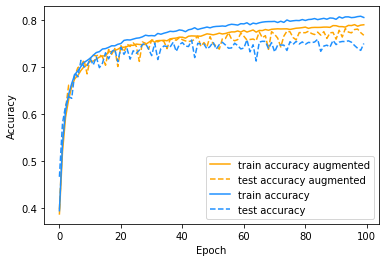

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_01_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_01_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_01_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_01_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.25

In [ ]:
width_multiplier = 0.25
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_025_no_aug_history = train_model(width_multiplier, params)

Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_101 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_600 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_600 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_601 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_601 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_300 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_602 (Conv2D)          (None, 16, 16, 16)        46

Accuracy: 0.806
Model Name: wm_025_no_aug_quantized.tflite, Quantized: True
Model Size: 111.00 KB


Accuracy: 0.8076


In [ ]:
width_multiplier = 0.25
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
    # 'easier_data_augmentation': True,
}
_, wm_025_aug_history = train_model(width_multiplier, params)

Model: "model_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_78 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_606 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_606 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_607 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_607 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_303 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.8414
Model Name: wm_025_aug_quantized.tflite, Quantized: True
Model Size: 111.00 KB


Accuracy: 0.8398


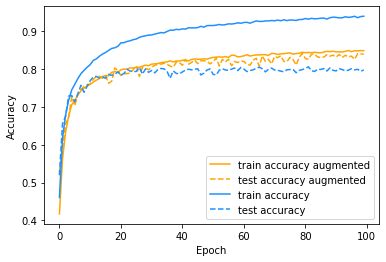

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_025_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_025_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_025_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_025_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.5

In [ ]:
width_multiplier = 0.50
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_050_no_aug_history = train_model(width_multiplier, params)

Model: "model_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_103 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_612 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_612 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_613 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_613 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_306 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_614 (Conv2D)          (None, 16, 16, 32)        92

Accuracy: 0.8304
Model Name: wm_05_no_aug_quantized.tflite, Quantized: True
Model Size: 359.31 KB


Accuracy: 0.83


In [ ]:
width_multiplier = 0.50
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
}
_, wm_050_aug_history = train_model(width_multiplier, params)

Model: "model_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_104 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_79 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_618 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_618 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_619 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_619 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_309 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.8747
Model Name: wm_05_aug_quantized.tflite, Quantized: True
Model Size: 359.31 KB


Accuracy: 0.8732


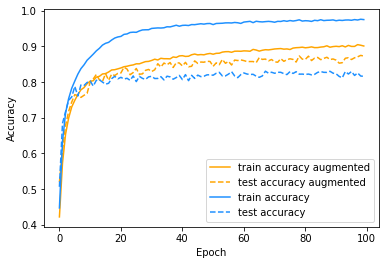

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_050_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_050_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_050_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_050_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.75

In [ ]:
width_multiplier = 0.75
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_075_no_aug_history = train_model(width_multiplier, params)

Model: "model_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_105 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_624 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_624 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_625 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_625 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_312 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_626 (Conv2D)          (None, 16, 16, 48)        13

Accuracy: 0.8379
Model Name: wm_075_no_aug_quantized.tflite, Quantized: True
Model Size: 767.09 KB


Accuracy: 0.836


#### With Augmentation

In [ ]:
width_multiplier = 0.75
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
}
_, wm_075_aug_history = train_model(width_multiplier, params)

Model: "model_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_106 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_80 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_630 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_630 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_631 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_631 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_315 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.8906
Model Name: wm_075_aug_quantized.tflite, Quantized: True
Model Size: 767.09 KB


Accuracy: 0.8857


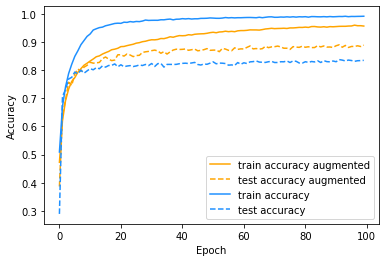

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_075_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_075_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_075_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_075_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 1.0

In [ ]:
width_multiplier = 1.0
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_10_no_aug_history = train_model(width_multiplier, params)

Model: "model_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_636 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_636 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_637 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_637 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_318 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_638 (Conv2D)          (None, 16, 16, 64)        18

Accuracy: 0.8442
Model Name: wm_10_no_aug_quantized.tflite, Quantized: True
Model Size: 1334.41 KB


Accuracy: 0.8452


In [ ]:
width_multiplier = 1.0
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
}
_, wm_10_aug_history = train_model(width_multiplier, params)

Model: "model_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_81 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_642 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_642 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_643 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_643 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_321 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.8941
Model Name: wm_10_aug_quantized.tflite, Quantized: True
Model Size: 1334.41 KB


Accuracy: 0.8928


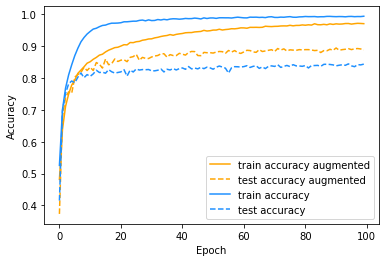

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_10_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_10_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_10_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_10_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 1.4

In [ ]:
width_multiplier = 1.4
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'dropout': 0.3,
    'data_augmentation': True,
}
wm_14_aug, wm_14_aug_history = train_model(width_multiplier, params, epochs=100)

Model: "model_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_82 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_648 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_648 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_649 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_649 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_324 (MaxPoolin (None, 16, 16, 32)        0 

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_gmenghani.kernel.gmenghani.1600443878033.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/tensorflow/python/keras/engine/training.py:1950: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Accuracy: 0.9086
Model Name: wm_14_aug_quantized.tflite, Quantized: True
Model Size: 2572.82 KB


Accuracy: 0.9082


In [ ]:
width_multiplier = 1.4
params = {
    'learning_rate': 5e-4,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-4,
    'data_augmentation': False,
}
_, wm_14_no_aug_history = train_model(width_multiplier, params, epochs=100)

Model: "model_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_110 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_654 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_654 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_655 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_655 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_327 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_656 (Conv2D)          (None, 16, 16, 90)        26

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_gmenghani.kernel.gmenghani.1600443878033.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/tensorflow/python/keras/engine/training.py:1950: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Accuracy: 0.8582
Model Name: wm_14_no_aug_quantized.tflite, Quantized: True
Model Size: 2572.82 KB


Accuracy: 0.8564


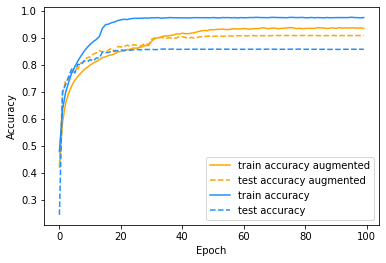

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_14_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_14_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_14_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_14_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

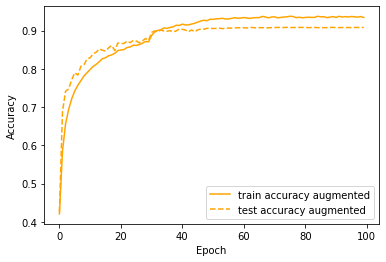

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_14_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_14_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

# plt.plot(wm_14_no_aug_history['categorical_accuracy'],
#          label='train accuracy',
#          c='dodgerblue', ls='-')
# plt.plot(wm_14_no_aug_history['val_categorical_accuracy'],
#          label='test accuracy',
#          c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

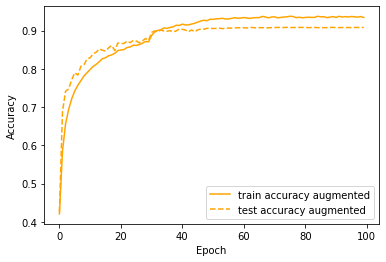

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_14_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_14_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

# plt.plot(wm_14_no_aug_history['categorical_accuracy'],
#          label='train accuracy',
#          c='dodgerblue', ls='-')
# plt.plot(wm_14_no_aug_history['val_categorical_accuracy'],
#          label='test accuracy',
#          c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

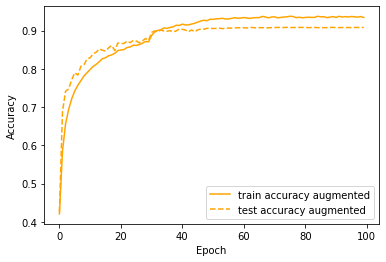

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_14_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_14_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

# plt.plot(wm_14_no_aug_history['categorical_accuracy'],
#          label='train accuracy',
#          c='dodgerblue', ls='-')
# plt.plot(wm_14_no_aug_history['val_categorical_accuracy'],
#          label='test accuracy',
#          c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Training Models w/ Distillation

In [ ]:
def prepare_teacher_model(teacher_model, test_dataset_x, test_dataset_y):
  teacher_model_with_logits = keras.Model(teacher_model.inputs, 
                                          teacher_model.layers[-2].output)
  teacher_model_with_logits.summary()
  teacher_model_with_logits.compile(metrics=keras.metrics.CategoricalAccuracy())
  teacher_model_with_logits.evaluate(test_dataset_x, test_dataset_y)

  for layer in teacher_model_with_logits.layers:
    layer.Trainable = False
  
  return teacher_model_with_logits

teacher_model_with_logits = prepare_teacher_model(wm_14_aug, cifar10_test_x, 
                                                  cifar10_test_y)

Model: "model_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_82 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_648 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_648 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_649 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_649 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_324 (MaxPoolin (None, 16, 16, 32)        0 

In [ ]:
class Distiller(keras.Model):
  def __init__(self, student, teacher):
      super(Distiller, self).__init__()
      self.teacher = teacher
      self.student = student

  def compile(
      self,
      optimizer,
      metrics,
      student_loss_fn,
      distillation_loss_fn,
      alpha=0.1,
      temperature=3,
  ):
    super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
    self.student_loss_fn = student_loss_fn
    self.distillation_loss_fn = distillation_loss_fn
    self.alpha = alpha
    self.temperature = temperature

  def call(self, inputs, training=None, mask=None):
    return self.student(inputs, training=training)

  def train_step(self, data):
    # Unpack data
    x, y = data

    # Forward pass of teacher
    teacher_predictions = self.teacher(x, training=False)

    with tf.GradientTape() as tape:
      # Forward pass of student
      student_predictions = self.student(x, training=True)

      # Compute losses
      student_loss = self.student_loss_fn(y, student_predictions)
      # distillation_loss = 0.0
      distillation_loss = self.distillation_loss_fn(
          tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
          tf.nn.softmax(student_predictions / self.temperature, axis=1),
      )
      loss = student_loss + self.alpha * distillation_loss

    # Compute gradients
    trainable_vars = self.student.trainable_variables
    # gradients = tape.gradient(loss, trainable_vars)

    # Update weights
    # self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.optimizer.minimize(loss, trainable_vars, tape=tape)

    # Update the metrics configured in `compile()`.
    self.compiled_metrics.update_state(y, student_predictions)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update({
        "student_loss": student_loss, 
        # "distillation_loss": distillation_loss
    })
    return results

  def test_step(self, data):
    # Unpack the data
    x, y = data

    # Compute predictions
    y_prediction = self.student(x, training=False)

    # Calculate the loss
    student_loss = self.student_loss_fn(y, y_prediction)

    # Update the metrics.
    self.compiled_metrics.update_state(y, y_prediction)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update({'student_loss': student_loss})
    return results

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

def get_compiled_distilled_model(
    teacher_model_with_logits,
    num_classes=10,
    width_multiplier=1.0,
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    # student_loss_fn=CategoricalCrossentropy(),
    distillation_loss_fn=CategoricalCrossentropy(from_logits=True),
    metric_fn='categorical_accuracy',
    params={},
    hp=None):
  if hp:
    pass
  else:
    learning_rate = params.get('learning_rate', 1e-3)
    alpha = params.get('alpha', 0.3)
    temperature = params.get('temperature', 1.0)
  
  # Make the model not append a softmax activation layer at the end.
  params['only_logits'] = True
  student_model = base_model(
      num_classes, width_multiplier=width_multiplier, params=params)

  compiled_distilled_model = Distiller(student=student_model, 
                        teacher=teacher_model_with_logits)
  compiled_distilled_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=metric_fn,
      student_loss_fn=student_loss_fn,
      distillation_loss_fn=distillation_loss_fn,
      alpha=alpha,
      temperature=temperature,
  )

  # Build and compile the student model so that it can be evaluated and exported.
  student_model.build(teacher_model_with_logits.input_shape)
  student_model.compile(loss=student_loss_fn, metrics=metric_fn)
  return compiled_distilled_model, student_model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def train_model_with_distillation(
    width_multiplier, 
    teacher_model_with_logits=None,
    params={}, 
    batch_size=128, 
    epochs=100):
  model_name = 'wm_{}_{}{}'.format(
      str(width_multiplier).replace('.', ''),
      ('aug' if params.get('data_augmentation', False) else 'no_aug'),
      ('_dist' if teacher_model_with_logits else ''),
  )

  if teacher_model_with_logits:
    # We are doing distillation.
    model_to_train, model_to_deploy = get_compiled_distilled_model(
      teacher_model_with_logits, 
      width_multiplier=width_multiplier,
      params=params)
    
    lr_reducer = ReduceLROnPlateau(
        # monitor='val_student_loss',
        monitor='val_categorical_accuracy',
        factor=np.sqrt(0.1),
        cooldown=0,
        patience=5,
        min_lr=0.5e-6)
  else:
    # Training the model solo.
    model_to_train = get_compiled_model(
        width_multiplier=width_multiplier,
        params=params)
    model_to_deploy = model_to_train

    lr_reducer = ReduceLROnPlateau(
        factor=np.sqrt(0.1),
        cooldown=0,
        patience=5,
        min_lr=0.5e-6)

  model_to_deploy.summary()

  # Now we can train the model.
  model_to_train_history = model_to_train.fit(
      cifar10_train_x, 
      cifar10_train_y, 
      batch_size=batch_size, 
      epochs=epochs, 
      validation_data=(cifar10_test_x, cifar10_test_y),
      callbacks=[best_checkpoint_callback(model_name), lr_reducer],
      # callbacks=[best_checkpoint_callback(model_name)],
      shuffle=True)

  model_to_train = load_best_checkpoint(model_to_train, model_name)
  model_to_deploy.evaluate(cifar10_test_x, cifar10_test_y)

  convert_and_eval(model_to_deploy, model_name, False, cifar10_test_x, 
                   cifar10_test_y)
  convert_and_eval(model_to_deploy, model_name, True, cifar10_test_x, 
                   cifar10_test_y)

  persist_history(model_to_train_history.history, model_name)
  return model_to_train, model_to_train_history.history

### Width Multiplier = 0.05

In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'alpha': 2.0,
    'data_augmentation': True,
    'easier_data_augmentation': True,
}
_, wm_005_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.05, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params, epochs=100)

Model: "model_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_111 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_83 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_660 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_660 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_661 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_661 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_330 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.7289
Model Name: wm_005_aug_dist_quantized.tflite, Quantized: True
Model Size: 26.68 KB


Accuracy: 0.727


In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'alpha': 1.0,
    'data_augmentation': False,
}
_, wm_005_no_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.05, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_112 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_666 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_666 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_667 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_667 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_333 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_668 (Conv2D)          (None, 16, 16, 3)         86

Accuracy: 0.6916
Model Name: wm_005_no_aug_dist_quantized.tflite, Quantized: True
Model Size: 26.68 KB


Accuracy: 0.6875


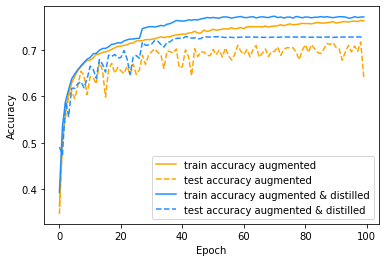

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_005_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_005_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_005_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_005_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.1

In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'alpha': 1.0,
    'data_augmentation': False,
}
_, wm_01_no_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.1, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_120 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_714 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_714 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_715 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_715 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_357 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_716 (Conv2D)          (None, 16, 16, 6)         17

Accuracy: 0.7698
Model Name: wm_01_no_aug_dist_quantized.tflite, Quantized: True
Model Size: 38.32 KB


Accuracy: 0.7691


In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'alpha': 0.5,
    'data_augmentation': True,
    'easier_data_augmentation': True,
}
_, wm_01_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.1, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params, epochs=100)

Model: "model_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_121 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_89 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_720 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_720 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_721 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_721 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_360 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.7893
Model Name: wm_01_aug_dist_quantized.tflite, Quantized: True
Model Size: 38.32 KB


Accuracy: 0.7855


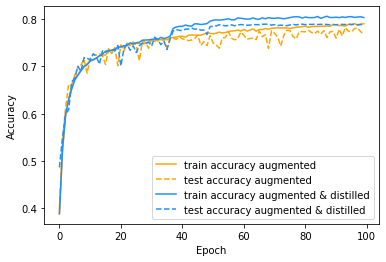

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_01_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_01_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_01_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_01_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

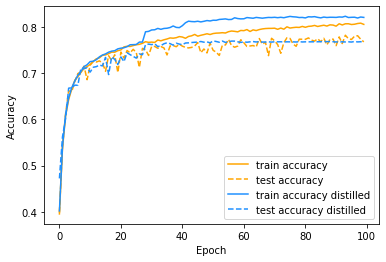

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_01_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='orange', ls='-')
plt.plot(wm_01_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='orange',ls='--')

plt.plot(wm_01_no_aug_dist_history['categorical_accuracy'],
         label='train accuracy distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_01_no_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.25

In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'alpha': 1.0,
    'data_augmentation': True,
}
_, wm_025_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.25, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_115 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_85 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_684 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_684 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_685 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_685 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_342 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.8451
Model Name: wm_025_aug_dist_quantized.tflite, Quantized: True
Model Size: 110.77 KB


Accuracy: 0.8418


100


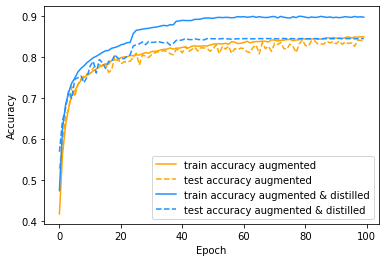

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_025_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_025_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

print(len(wm_025_aug_dist_history['categorical_accuracy']))

plt.plot(wm_025_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_025_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.5

In [ ]:
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'alpha': 1.0,
    'data_augmentation': True,
}
_, wm_050_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.5, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_123 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_91 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_732 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_732 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_733 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_733 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_366 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.8803
Model Name: wm_05_aug_dist_quantized.tflite, Quantized: True
Model Size: 359.09 KB


Accuracy: 0.8786


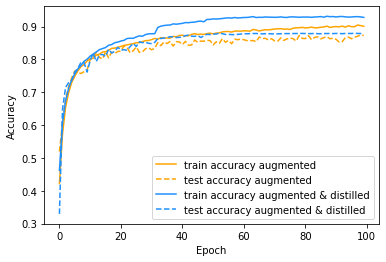

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_050_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_050_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_050_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_050_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.75

In [ ]:
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
    'alpha': 1.0,
    'temperature': 1.0
}
_, wm_075_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.75, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params,
    epochs=100)

Model: "model_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_117 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_87 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_696 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_696 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_697 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_697 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_348 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.8951
Model Name: wm_075_aug_dist_quantized.tflite, Quantized: True
Model Size: 766.87 KB


Accuracy: 0.8929


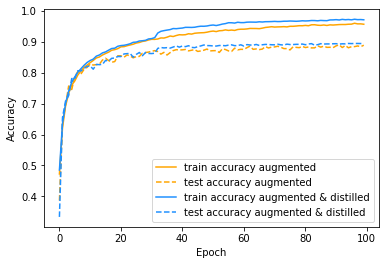

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_075_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_075_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_075_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_075_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 1.0

In [ ]:
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'alpha': 1.0,
    'data_augmentation': True,
}
_, wm_10_aug_dist_history = train_model_with_distillation(
    width_multiplier=1.0, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_118 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_88 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_702 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_702 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_703 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_703 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_351 (MaxPoolin (None, 16, 16, 32)        0 

Accuracy: 0.8992
Model Name: wm_10_aug_dist_quantized.tflite, Quantized: True
Model Size: 1334.18 KB


Accuracy: 0.8991


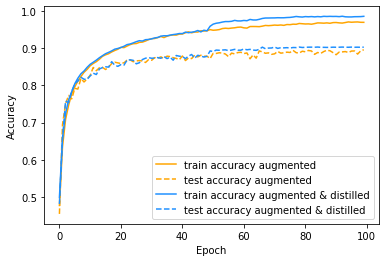

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_10_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_10_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_10_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_10_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 1.4

In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-4,
    'alpha': 1.0,
    'data_augmentation': True,
}
_, wm_14_aug_dist_history = train_model_with_distillation(
    width_multiplier=1.4, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_95 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_74 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_564 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_564 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_565 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_565 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_282 (MaxPoolin (None, 16, 16, 32)        0  

Accuracy: 0.8978
Model Name: wm_10_aug_dist_quantized.tflite, Quantized: True
Model Size: 1334.16 KB


Accuracy: 0.8951
